In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [46]:
data = load_iris()
dir(data)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [47]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
data = pd.concat([X, y], axis=1)
print(X.shape)
print(y.shape)
print(data.head())

(150, 4)
(150,)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [103]:
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [50]:
# # in case for missing values

# # 时间序列特征
# df = df.sort_values(["asset", "date"])
# df["px"] = df.groupby("asset")["px"].ffill(limit=3)  # 例：最多填 3 天

# # 横截面特征（同一天很多标的）
# # 同一日期内按行业/市值桶填 median，并保留缺失flag
# df["pe_isna"] = df["pe"].isna().astype(int)
# df["pe"] = df.groupby(["date", "sector"])["pe"].transform(lambda s: s.fillna(s.median()))

In [51]:
data['target'].value_counts()
# pay attention to imbalanced data

target
0    50
1    50
2    50
Name: count, dtype: int64

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
    random_state=42, stratify=y)
    # stratify: ensure the same proportion of classes in the train and test sets

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
# doesn't need, can use cross validation

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

array([[<Axes: title={'center': 'petal length (cm)'}, xlabel='[target]'>,
        <Axes: title={'center': 'petal width (cm)'}, xlabel='[target]'>],
       [<Axes: title={'center': 'sepal length (cm)'}, xlabel='[target]'>,
        <Axes: title={'center': 'sepal width (cm)'}, xlabel='[target]'>]],
      dtype=object)

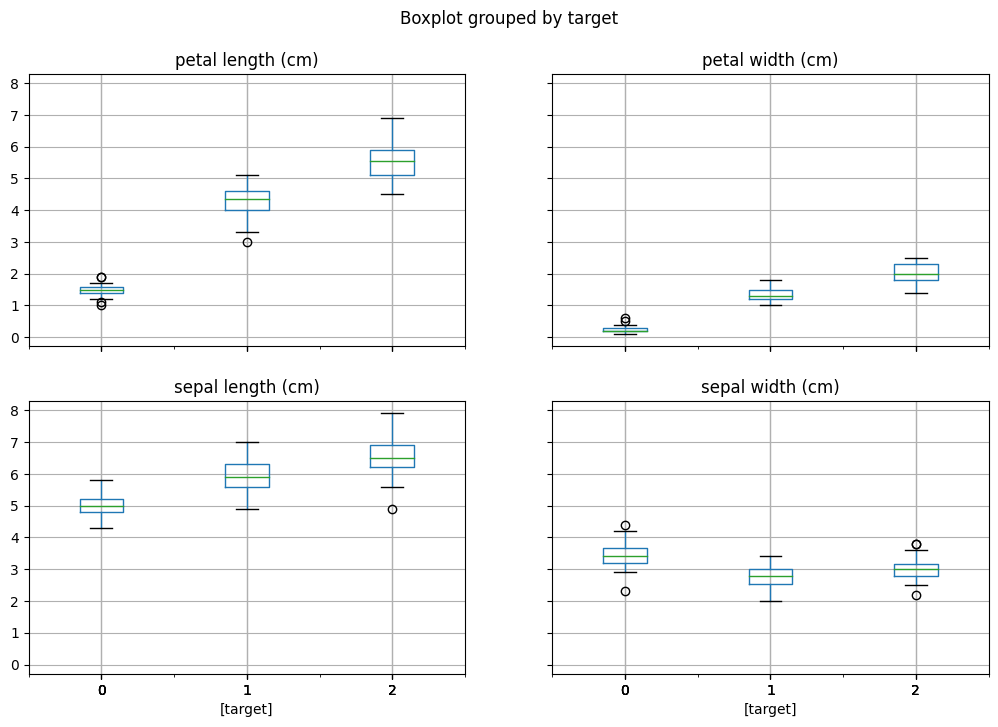

In [53]:
data.boxplot(by='target', figsize=(12, 8))
# data.groupby('target').boxplot(figsize=(12, 8))

In [ ]:
# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(penalty="l2", max_iter=2000).fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# y_pred_proba = clf.predict_proba(X_test)

For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used. These splitters are instantiated with shuffle=False so the splits will be the same across calls.

for multi-class:
- balanced_accuracy: average of recall across classes (each class counts equally). --> care about not missing minority classes
- f1_macro: compute F1 for each class (treating that class as “positive” vs all others), then average equally across classes. --> care about both missing and over-predicting minority classes

for binary-class:
- roc_auc (balanced, threshold free)
- average_precision (imbalanced when positives are rare)

Then set threshold on validation to achieve, e.g., recall ≥ 0.9

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", max_iter=2000))
])

param_grid = {"clf__C": np.logspace(-4, 4, 15)}
# use [k for k in pipe.get_params().keys() if k.startswith("clf__")] for check for all parameters
# np.linspace(0.0001, 1000, 15)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# tscv = TimeSeriesSplit(n_splits=5)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro", 
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

gs.fit(X_train, y_train)

best_idx = gs.best_index_
cvres = gs.cv_results_

mean_tr = cvres["mean_train_score"][best_idx]
mean_va = cvres["mean_test_score"][best_idx]
std_va  = cvres["std_test_score"][best_idx]

print("best params:", gs.best_params_)
print("CV train F1_macro:", mean_tr)
print("CV valid F1_macro:", mean_va, "±", std_va)
print("gap (train-valid):", mean_tr - mean_va)

best params: {'clf__C': 13.89495494373136}
CV train F1_macro: 0.983369511147289
CV valid F1_macro: 0.958473296251074 ± 0.011206010057387686
gap (train-valid): 0.024896214896214963


In [ ]:
# If you have a custom transform, wrap it
# from sklearn.preprocessing import FunctionTransformer

# pipe = Pipeline([
#     ("log1p", FunctionTransformer(lambda X: np.log1p(X), feature_names_out="one-to-one")),
#     ("clf", LogisticRegression())
# ])


In [66]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=13.89495494373136, max_iter=2000))])

In [ ]:
# feature importance
best_pipe = gs.best_estimator_
clf = best_pipe.named_steps["clf"]
clf.coef_ # single set of coefficients from the refit “best” model

array([[-1.62542957,  1.99473578, -3.68361447, -3.45903471],
       [ 1.1905469 , -0.15246885, -1.46099066, -1.37509586],
       [ 0.43488267, -1.84226693,  5.14460514,  4.83413057]])

In [104]:
best_pipe.named_steps["scaler"].get_feature_names_out()

array(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'], dtype=object)

interpretation: each row is for one class, coefficients for all features
for class 2, feature 2 and 3 significantly push up probability.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# important note: use best_pipe instead of clf!!! Becuase best_pipe incldues data processing steps
print(classification_report(y_train, best_pipe.predict(X_train)))
# Support = number of true samples of that class in the dataset you evaluated on.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.98      0.98      0.98        41
           2       0.97      0.97      0.97        39

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [ ]:
print(confusion_matrix(y_train, best_pipe.predict(X_train)))
# True class 0: predicted as 0 40 times (perfect), never as 1 or 2.
# True class 1: predicted as 1 40 times, misclassified as 2 1 time.
# True class 2: predicted as 2 38 times, misclassified as 1 1 time.


[[40  0  0]
 [ 0 40  1]
 [ 0  1 38]]


In [76]:
print(confusion_matrix(y_test, best_pipe.predict(X_test)))


[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


In [ ]:
# if it's a binary classification problem, we can plot the ROC curve

# from sklearn.metrics import RocCurveDisplay
# import matplotlib.pyplot as plt

# RocCurveDisplay.from_estimator(best_pipe, X_train, y_train)
# plt.show()
# If your model doesn’t support predict_proba, use decision_function(X_test) 
# instead.
# Make sure y_test is 0/1 and you’re plotting the intended “positive” class 
# (the [:, 1] column corresponds to best_pipe.classes_[1]).

# then we can choose the threshold according to the ROC curve

In [85]:
from sklearn.tree import DecisionTreeClassifier
pipe2 = Pipeline([
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "clf__max_depth": [2, 3, 4, 5, None],
    "clf__min_samples_leaf": [1, 2, 4, 8],
    "clf__min_samples_split": [2, 5, 10],
    "clf__ccp_alpha": [0.0, 1e-3, 1e-2],  # 小样本剪枝很有用
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs2 = GridSearchCV(pipe2, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, return_train_score=True)
gs2.fit(X_train, y_train)

best_pipe2 = gs2.best_estimator_


In [86]:
best_idx = gs2.best_index_
cvres = gs2.cv_results_

mean_tr = cvres["mean_train_score"][best_idx]
mean_va = cvres["mean_test_score"][best_idx]
std_va  = cvres["std_test_score"][best_idx]

print("best params:", gs2.best_params_)
print("CV train F1_macro:", mean_tr)
print("CV valid F1_macro:", mean_va, "±", std_va)
print("gap (train-valid):", mean_tr - mean_va)

best params: {'clf__ccp_alpha': 0.0, 'clf__max_depth': 4, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
CV train F1_macro: 0.9624565097719758
CV valid F1_macro: 0.958473296251074 ± 0.011206010057387738
gap (train-valid): 0.003983213520901807


In [80]:
clf2 = best_pipe2.named_steps["clf"]
clf2.feature_importances_

array([0.00603581, 0.        , 0.95478956, 0.03917463])

In [105]:
# 'DecisionTreeClassifier' object has no attribute 'get_feature_names_out'
X_train.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [81]:
print(classification_report(y_train, best_pipe2.predict(X_train)))
print(confusion_matrix(y_train, best_pipe2.predict(X_train)))
print(classification_report(y_test, best_pipe2.predict(X_test)))
print(confusion_matrix(y_test, best_pipe2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.95      0.95        41
           2       0.95      0.95      0.95        39

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

[[40  0  0]
 [ 0 39  2]
 [ 0  2 37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


Iris 这类数据里，类间分离很多时候用线性/近线性就能做得很好。
Logistic 是“低方差、强归纳偏置”的线性模型 → 泛化更稳。
Decision Tree 需要用轴对齐切分去逼近边界 → 有时会“切得更碎”或“切不出最佳形状”。

In [98]:
from sklearn.ensemble import RandomForestClassifier

pipe3 = Pipeline([
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 3, 5, 8],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt"],  # 小样本先固定，减少搜索噪声
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gs3 = GridSearchCV(pipe3, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, return_train_score=True)
gs3.fit(X_train, y_train)

best_pipe3 = gs3.best_estimator_

In [99]:
best_idx = gs3.best_index_
cvres = gs3.cv_results_

mean_tr = cvres["mean_train_score"][best_idx]
mean_va = cvres["mean_test_score"][best_idx]
std_va  = cvres["std_test_score"][best_idx]

print("best params:", gs3.best_params_)
print("CV train F1_macro:", mean_tr)
print("CV valid F1_macro:", mean_va, "±", std_va)
print("gap (train-valid):", mean_tr - mean_va)

best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 400}
CV train F1_macro: 0.9792643415284924
CV valid F1_macro: 0.95018315018315 ± 0.04082565069470224
gap (train-valid): 0.029081191345342372


In [ ]:
clf3 = best_pipe3.named_steps["clf"]
clf3.feature_importances_
# 'RandomForestClassifier' object has no attribute 'get_feature_names_out'

array([0.10305634, 0.02337863, 0.45316521, 0.42039982])

In [109]:
pd.Series(clf3.feature_importances_, index=X_train.columns).sort_values(ascending=False)

petal length (cm)    0.453165
petal width (cm)     0.420400
sepal length (cm)    0.103056
sepal width (cm)     0.023379
dtype: float64

In [ ]:
print(classification_report(y_train, best_pipe3.predict(X_train)))
print(confusion_matrix(y_train, best_pipe3.predict(X_train)))
print(classification_report(y_test, best_pipe3.predict(X_test)))
print(confusion_matrix(y_test, best_pipe3.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.93      0.95        41
           2       0.93      0.97      0.95        39

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

[[40  0  0]
 [ 0 38  3]
 [ 0  1 38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


在 Iris/类似数据上，线性边界本来就很强，StandardScaler + L2 Logistic 可能天然占优；RF 在小样本上更容易出现你看到的 std 更大。
所以你看到“RF 没显著超过 logistic”并不反常。